<a id="Subcluster_myeloid"></a>
## Sub-cluster monocytes

- [1. Load raw data](#loadM)
- [2. Subclustering 1 - remove doublets](#cluster_M1)
- [3. Subclustering 2 - classify cell types](#cluster_M2)
- [4. Output results figures](#figuresM)

In [1]:
import os
adir = '../../../../../data/InVivo/Seqwell/'
project_name = 'invivo_all_20200318_mmul8_V4_fixid'
abase = os.path.join(adir, project_name)
gcs = False
abase

'../../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid'

In [2]:
count_thresh=0
gene_thresh=300
mitothresh=.1
nhvgs = None
logstatus = 'log'

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Functions for reading files straight from google cloud storage
import sys
sys.path.append('../../../../Code')
from utils import save_adata, read_adata, subcluster_iteration

import palettable
from IPython.display import display

from joblib import parallel_backend

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, vector_friendly=False, ipython_format='png')


dpi_colors2 = np.array([x for x in palettable.tableau.TrafficLight_9.hex_colors])
dpimap2 = dict(zip(['0', '1', '2', '3', '4', '5', '6', '7', '8'], dpi_colors2[[8,8,5, 7, 4, 1, 6,3,0]]))
dpimap2['0'] = palettable.tableau.TableauMedium_10.hex_colors[-1]

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.4.post1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [5]:
results_dir = '../../../../../results'


<a id="loadM"></a>

## Load raw data and previous clustering results

In [39]:
annot_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
adata_annot = read_adata(annot_file, gcs=gcs)
print(annot_file)

Only considering the two last: ['.scale', '.h5ad'].
Only considering the two last: ['.scale', '.h5ad'].
../../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.NoBOD.Blacklist.HVGs_None.scale.h5ad


In [8]:
adata_raw = sc.AnnData(adata_annot.raw.X, obs=adata_annot.obs, var=adata_annot.raw.var, uns=adata_annot.uns)
adata_raw = adata_raw[adata_raw.obs['leiden_lab_group_2'].isin(['Neut', 'Mono/DC', 'Platelet']), :]

adata_raw_full = adata_raw.copy()

adata_raw = adata_raw[:,~(adata_raw.var['Combined_Blacklist'] | adata_raw.var['CC_Blacklist'])]
sc.pp.filter_genes(adata_raw, min_cells=10)

sc.pp.normalize_per_cell(adata_raw, counts_per_cell_after=10000)
sc.pp.log1p(adata_raw)

sc.pp.normalize_per_cell(adata_raw_full, counts_per_cell_after=10000)
sc.pp.log1p(adata_raw_full)

adata_raw.raw = adata_raw_full

filtered out 3742 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [9]:
adata_raw.obs['leiden'].value_counts()

8     3862
9     3348
10    2737
11    2626
13    1238
15     683
16     308
Name: leiden, dtype: int64

<a id="cluster_M1"></a>
## Iterative subclustering 1 - removes doublets

In [10]:
genestoplot = ['CD14', 'FCGR3', 'MPO', 'S100A9', 'NR1H3', 'CD3D', 'MS4A1', 'IGKC', 'CD177','log10_EBOV_TPT', 'MKI67', 'HBB', 'frz_status', 'MAMU-DPB', 'IRF8', 'FLT3', 'MAMU-DQA1', 'PPBP']

In [11]:
(adata_raw.shape[0]*.001)

14.802

In [12]:
30 / adata_raw.shape[0]

0.002026753141467369

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01)


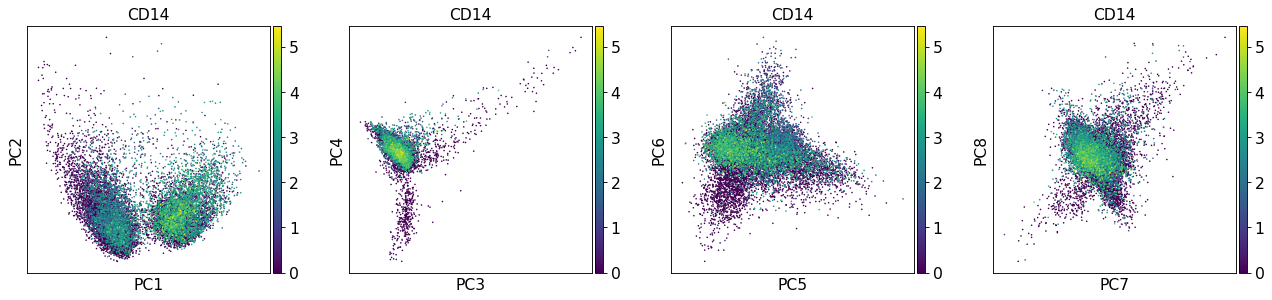

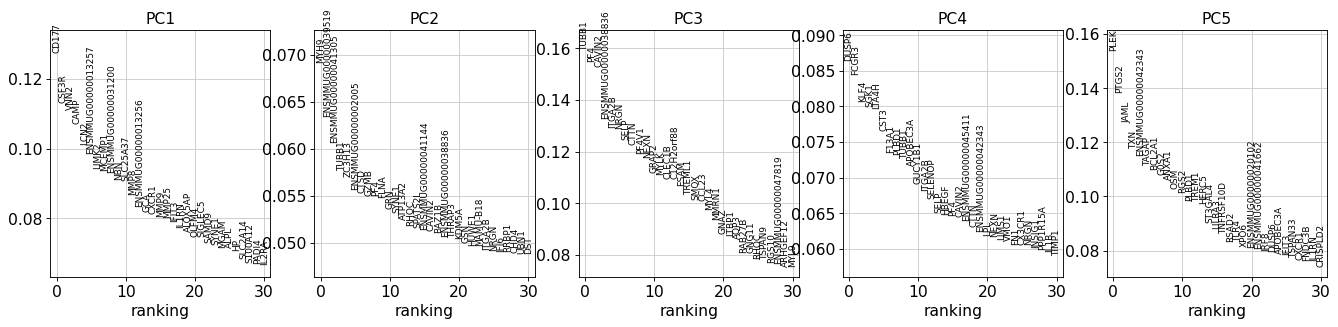

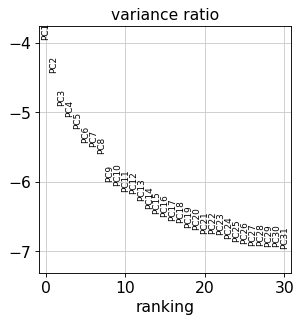

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).
computing neighbors


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../..

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:24)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:08)


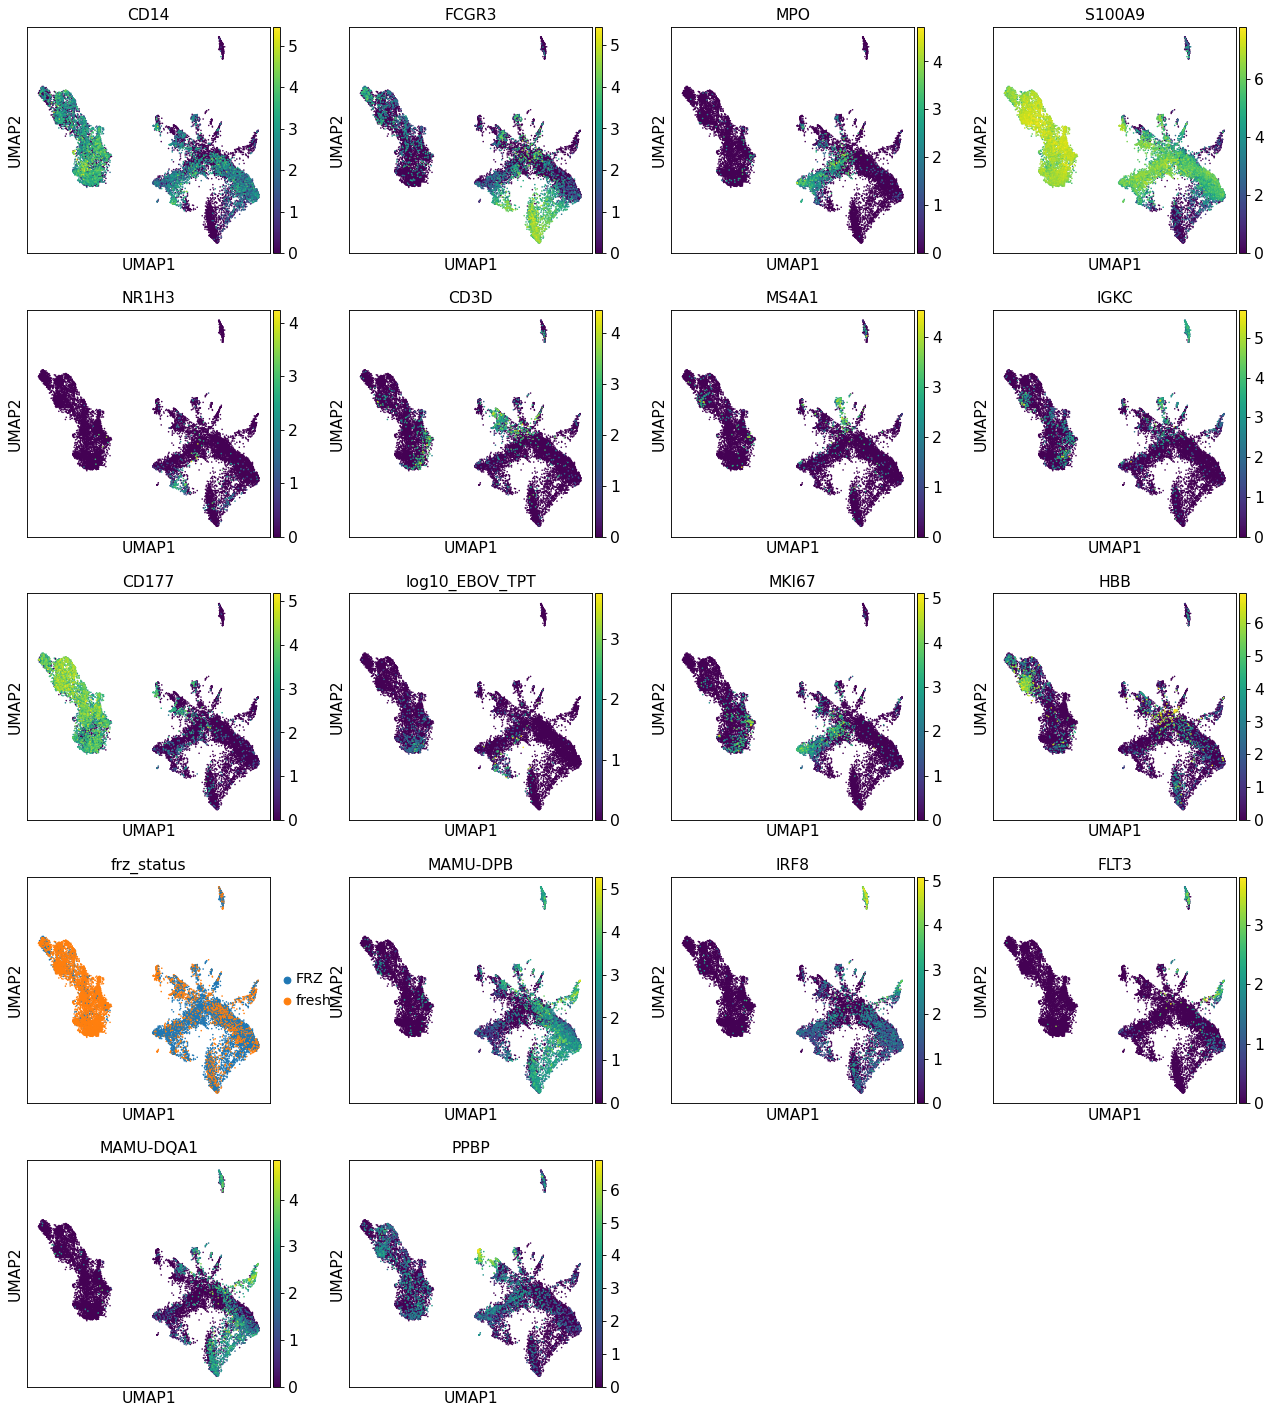

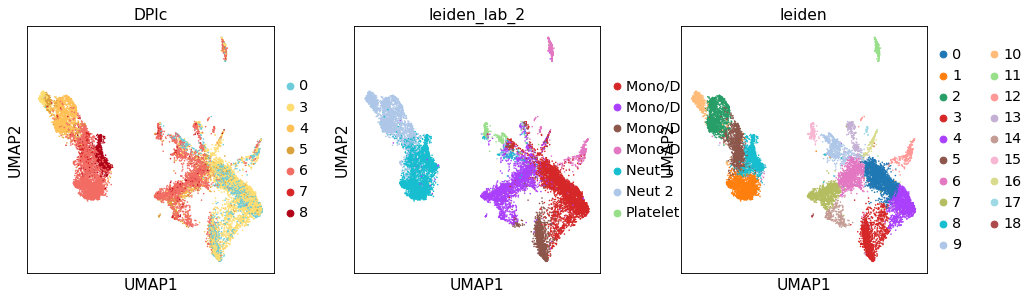

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:22)


0                   1                   2  \
0                  VIM               OLFM4               IFIT2   
1                  LYZ               IL2RA               CD177   
2                  FOS                LCN2              S100A9   
3                 PSAP                SOD2               IL1RN   
4                ANXA1                VNN2                SOD2   
5              S100A10  ENSMMUG00000047461                SELL   
6                 KLF4              MCEMP1               IFIT1   
7               PABPC1              S100A9               ISG15   
8                DUSP6                CTSD               IFIT3   
9                ANXA2                MMP8              NFKBIA   
10               RPL17                FYB1              BCL2A1   
11                KLF6                 NBN            SLC25A37   
12                MNDA                CAMP              S100A8   
13  ENSMMUG00000003867              NFKBIA                PLEK   
14             GADD45B  ENSMMUG00000028701                 GCA   
15               CD163               IFIT1  ENSMMUG00000013257   
16                RPS6             SLC39A8                GBP2   
17               RPLP1                LCP1               HERC5   
18              S100A4  ENSMMUG00000038258                IRF7   
19                CTSB               GRINA               LITAF   

                     3                   4                   5  \
0                  CFD                 VIM               CD177   
1                FCGR3                 LYZ              S100A9   
2                 PSAP                CST3                CAMP   
3                LTA4H                PSAP              RNF213   
4               PECAM1               CD163               SYNE1   
5                ITGB2               TGFBI                LCN2   
6             MAMU-DPA              PABPC1               LITAF   
7   ENSMMUG00000045411                 FN1                FYB1   
8              SELENOP              CDKN1A                SELL   
9                 VMO1               DUSP6  ENSMMUG00000031200   
10               ITGAL            MAMU-DRA              S100A8   
11               MS4A7                KLF4              MCEMP1   
12               ITM2B               ANXA2               LIMK2   
13  ENSMMUG00000013289            MAMU-DPA                MMP8   
14               ITGA4            MAMU-DMA                IFI6   
15            MAMU-DRA  ENSMMUG00000014402                 MX1   
16              PTP4A2                SGK1              CORO1A   
17                 LPL               HBEGF               SAMD9   
18                KLF4                KLF6              ZCCHC6   
19                CTSB             SLC25A6                MMP9   

                     6                   7                   8  \
0                IFI27                 CLU               IFI27   
1                  LYZ                 MPO              S100A9   
2   ENSMMUG00000014402              GIMAP4  ENSMMUG00000031200   
3                 CTSB               IFI27              S100A8   
4                ANXA2  ENSMMUG00000014402              MAMU-E   
5                RPS15                LAP3                  HP   
6                RPL35              ANP32B               CSF3R   
7                 LAP3               H2AFV             MAMU-A3   
8                  CLU              LGALS1  ENSMMUG00000039519   
9               GIMAP4              NUCKS1  ENSMMUG00000013257   
10                COX2               MKI67                LCN2   
11              S100A4               PSMA2                 GRN   
12             S100A10               STAP1              MAMU-A   
13               ACTG1              SNRPD2                VNN2   
14               RPLP0                 LYZ              RNF213   
15               RPL11                TFEC                SELL   
16               RPS19              NDUFC2               CD177   
17                 MPO               ACTG1  ENSMMUG00000042

In [13]:
adata_1 = subcluster_iteration(adata_raw, min_cells=10, nhvgs=nhvgs, npcs=19,
                        n_neighbors=30,
                        min_dist=0.1, spread=2.0,resolution=1.5,
                        umap_genestoplot=genestoplot, pc_genestoplot=['CD14'],
                        other_plot=['DPIc', 'leiden_lab_2', 'leiden'], harmony=True,
                        harmony_theta=.5)

In [14]:
adata_1.obs['leiden'].value_counts()

0     1841
1     1672
2     1425
3     1377
4     1359
5     1146
6     1090
7     1068
8     1005
9      693
10     521
11     329
12     320
13     301
14     277
15     177
16     160
17      28
18      13
Name: leiden, dtype: int64

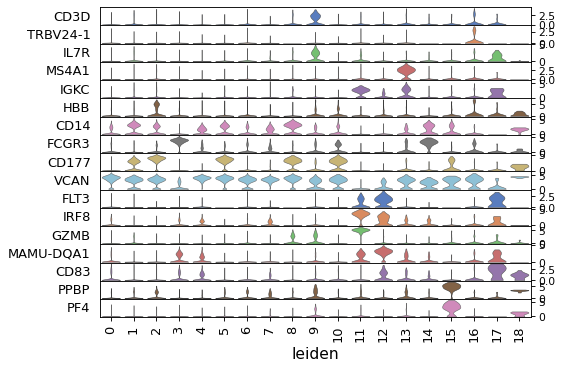

In [15]:
_ =sc.pl.stacked_violin(adata_1, var_names=['CD3D','TRBV24-1', 'IL7R', 'MS4A1', 'IGKC', 'HBB',
                                            'CD14', 'FCGR3', 'CD177', 'VCAN', 'FLT3', 'IRF8', 'GZMB', 'MAMU-DQA1', 'CD83', 'PPBP', 'PF4'], groupby='leiden', swap_axes=True)

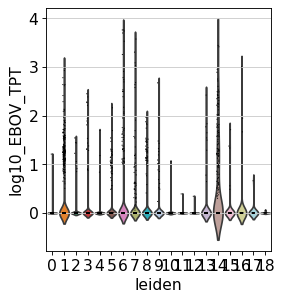

In [16]:

sc.pl.violin(adata_1, keys=['log10_EBOV_TPT'], groupby='leiden')

In [17]:
doublet_vals = ['9', '13', '15', '16', '18']
doublet_ind = adata_1.obs.index[adata_1.obs['leiden'].isin(doublet_vals)]
adata_annot.obs.loc[doublet_ind, 'Doublet'] = True

<a id="cluster_M2"></a>
## Iterative subclustering 2 - classify cell types

Trying to set attribute `.obs` of view, copying.


filtered out 334 genes that are detectedin less than 10 cells
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:03)


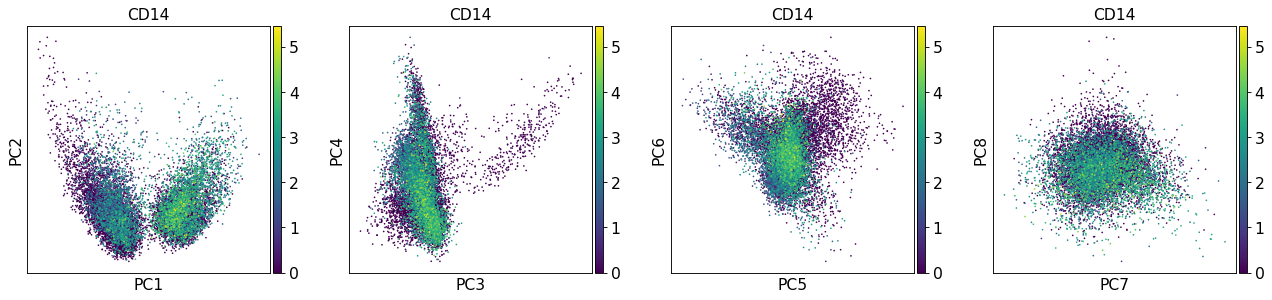

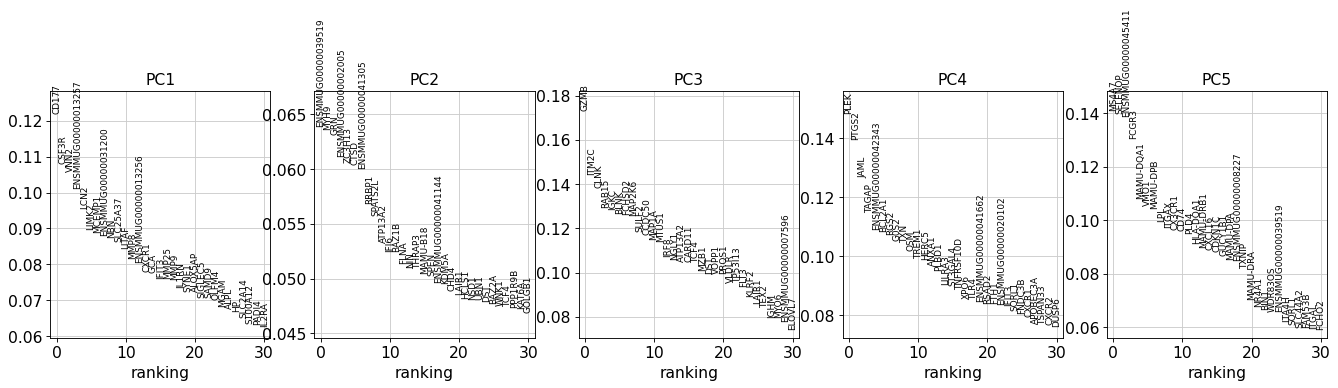

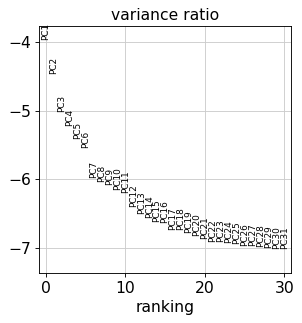

computing neighbors
    using 'X_pca' with n_pcs = 17


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:20)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:09)


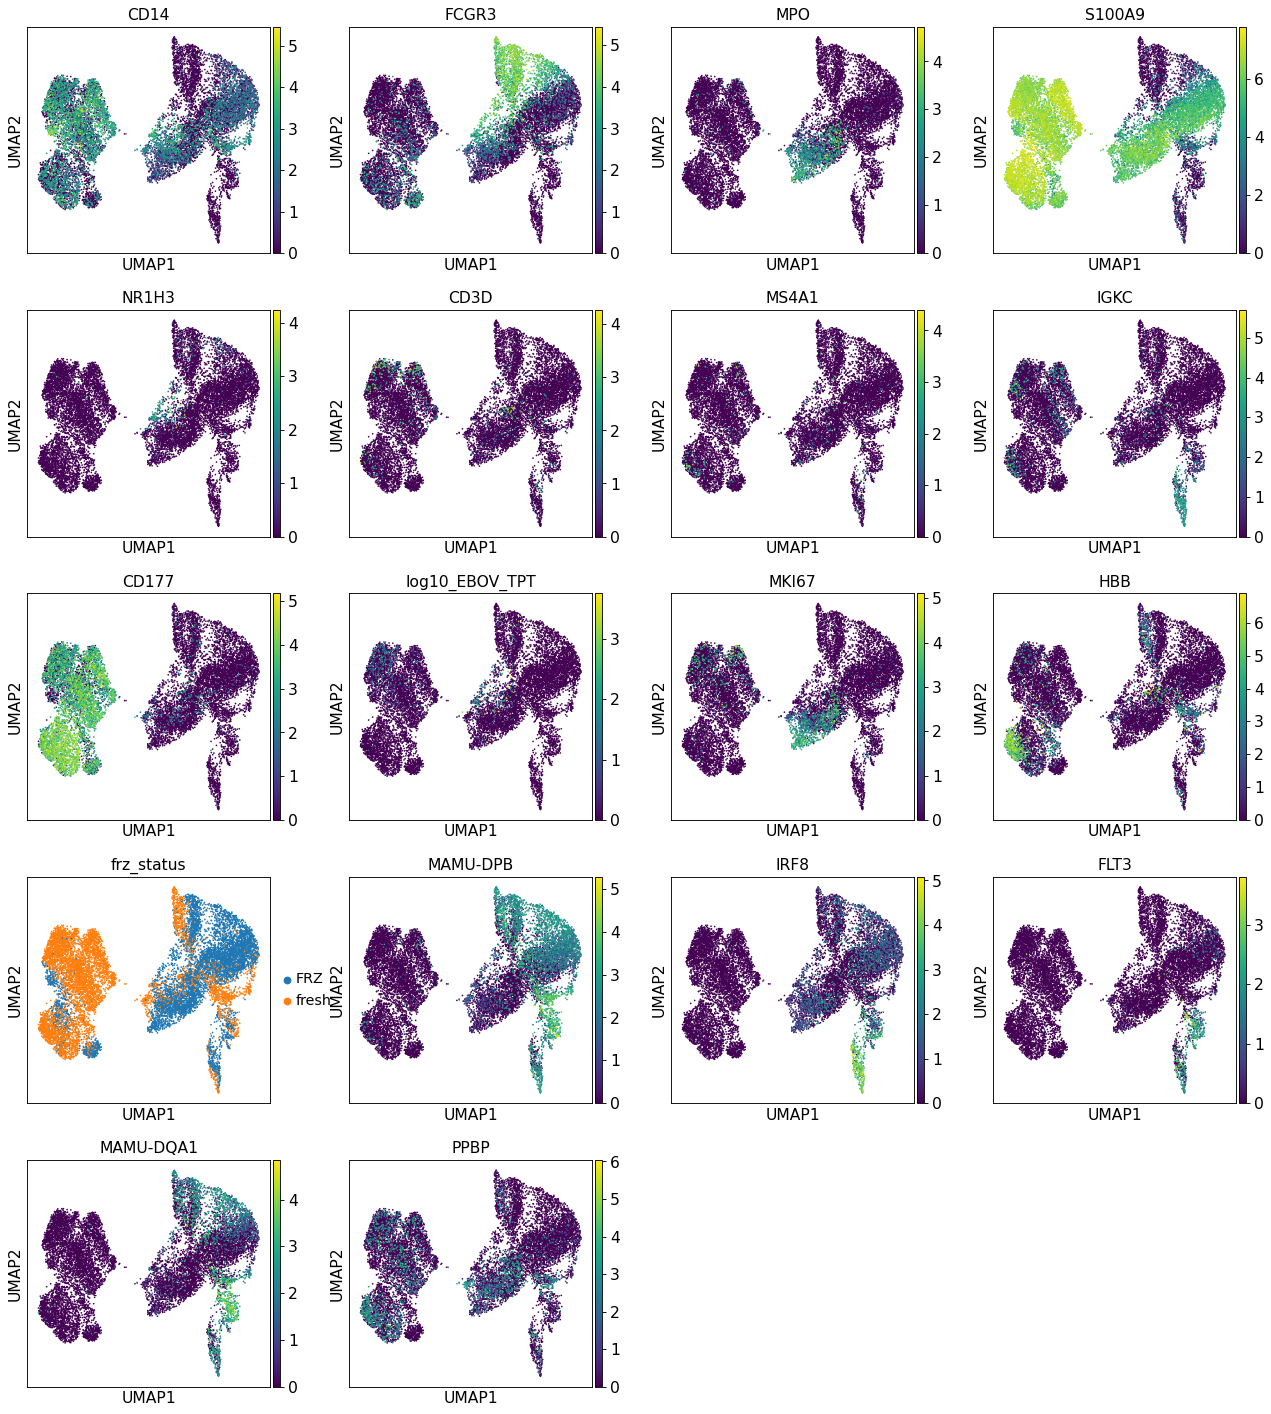

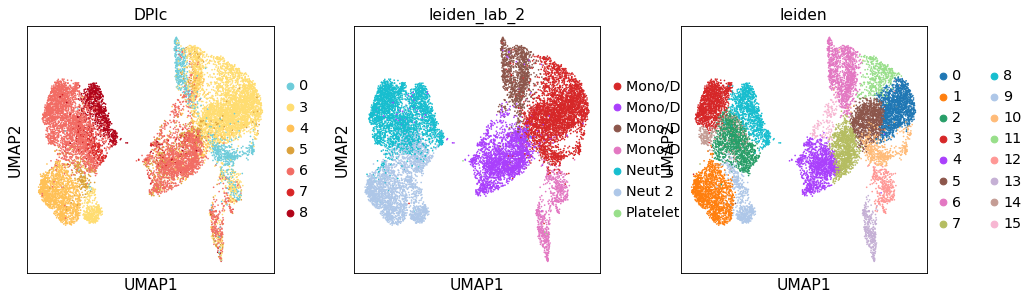

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:19)


0                   1                   2  \
0                  VIM               IFIT2              RNF213   
1                  LYZ               CD177               CD177   
2                CD163              S100A9                FYB1   
3                ANXA1               IL1RN                LCN2   
4                  FOS                SELL                CAMP   
5                 KLF4                SOD2              S100A9   
6                 KLF6               IFIT1               SYNE1   
7               PABPC1               ISG15              MCEMP1   
8                ANXA2              NFKBIA               LITAF   
9                  FN1              BCL2A1               LIMK2   
10  ENSMMUG00000014402               IFIT3                MMP8   
11             S100A10                 GCA  ENSMMUG00000038258   
12               DUSP6              S100A8               RFLNB   
13                CST3            SLC25A37                CTSD   
14               HBEGF                PLEK                SELL   
15             GADD45B  ENSMMUG00000013257              CORO1A   
16           SERPINB10                IRF7  ENSMMUG00000028701   
17               TGFBI               HERC5                IFI6   
18              CDKN1A                GBP2               CSF3R   
19                SGK1               LITAF               SAMD9   

                     3                   4                   5  \
0                OLFM4                 CLU                 LYZ   
1                IL2RA              GIMAP4                 VIM   
2                 VNN2                 MPO                 FOS   
3                 LCN2               IFI27               ANXA1   
4   ENSMMUG00000028701  ENSMMUG00000014402                KLF4   
5                 SOD2                LAP3               DUSP6   
6               S100A9              NUCKS1                TPT1   
7                 MMP8              ANP32B             S100A10   
8   ENSMMUG00000047461              LGALS1                KLF6   
9                 CAMP               H2AFV             GADD45B   
10              MCEMP1               PSMA4                PSAP   
11                FYB1               PSMA2  ENSMMUG00000003867   
12                CTSD               PSMA7                MNDA   
13              S100A8                P4HB               ANXA2   
14             SLC39A8                TFEC              PABPC1   
15              NFKBIA              NDUFC2               RPL17   
16               IFIT1            ATP6V1B2              RPL13A   
17                 NBN              SNRPD2  ENSMMUG00000014256   
18  ENSMMUG00000038258               DNPEP               RPS14   
19                LCP1               PSMB6               HIF1A   

                     6                   7                   8  \
0                  CFD               IFI27               IFI27   
1                FCGR3                 LYZ              S100A9   
2                LTA4H  ENSMMUG00000014402  ENSMMUG00000031200   
3                ITGB2               RPL35              S100A8   
4                MS4A7               RPS15                  HP   
5                 PSAP                CTSB              MAMU-E   
6               PECAM1               ANXA2             MAMU-A3   
7              SELENOP                COX2  ENSMMUG00000039519   
8                ITGAL                 CLU              MAMU-A   
9                 VMO1                LAP3               CSF3R   
10  ENSMMUG00000045411               RPLP0                LCN2   
11               ITM2B               RPS19                VNN2   
12            MAMU-DPA             S100A10  ENSMMUG00000013257   
13  ENSMMUG00000013289              GIMAP4                 GRN   
14               ITGA4               RPL11  ENSMMUG00000042067   
15  ENSMMUG00000017466               RPS11              RNF213   
16                 LPL              S100A4               CD177   
17              CX3CR1               ACTG1               AP

In [18]:
keep = adata_1.obs.index[~adata_1.obs['leiden'].isin(doublet_vals)]
Z = adata_raw[keep,:]
Z.obs['leiden_round1'] = adata_1.obs.loc[keep, 'leiden']

adata_2 = subcluster_iteration(Z, min_cells=10, nhvgs=nhvgs, npcs=17,
                        n_neighbors=30,
                        min_dist=0.5, spread=1.0,resolution=1.3,
                        umap_genestoplot=genestoplot, pc_genestoplot=['CD14'],
                        other_plot=['DPIc', 'leiden_lab_2', 'leiden'], harmony=False,
                        harmony_theta=.5, scale=True)

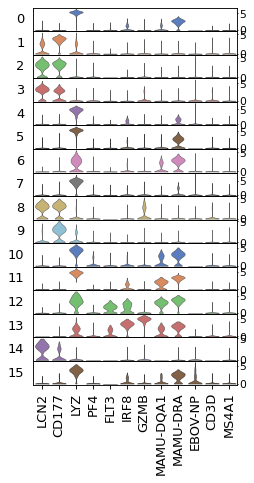

In [19]:
_ = sc.pl.stacked_violin(adata_2, var_names=[ 'LCN2', 'CD177', 'LYZ', 'PF4', 'FLT3', 'IRF8', 'GZMB', 'MAMU-DQA1', 'MAMU-DRA','EBOV-NP', 'CD3D', 'MS4A1'], groupby='leiden')

In [20]:
labmap = {'0':'Mono 1',
          '1':'Neut 1',
          '2':'Neut 2',
          '3':'Neut 3',
          '4':'Mono 2',
          '5':'Mono 3',
          '6':'Mono 4',
          '7':'Mono 5',
          '8':'Neut 4',
          '9':'Neut 5',
          '10':'Mono 6',
          '11':'Mono 7',
          '12':'cDC 1',
          '13':'pDC 1',
          '14':'Neut 6', 
          '15':'Mono 8'}

... storing 'leiden_lab' as categorical
... storing 'leiden_lab_group' as categorical


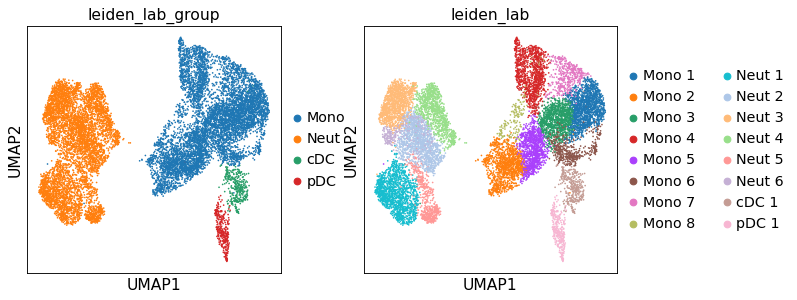

In [21]:
adata_2.obs['leiden_lab'] = adata_2.obs['leiden'].replace(labmap)
adata_2.obs['leiden_lab_group'] = adata_2.obs['leiden_lab'].apply(lambda x: x.split(' ')[0])

sc.pl.umap(adata_2, color=['leiden_lab_group', 'leiden_lab'])

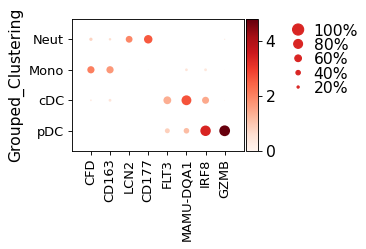

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[2.8, 0, 0.2, 0.5, 0.25])

In [22]:
celltype_order = ['Neut', 'Mono', 'cDC', 'pDC']
adata_2.obs['Grouped_Clustering'] = pd.Categorical(adata_2.obs['leiden_lab_group'].values, categories=celltype_order)
sc.pl.dotplot(adata_2, var_names=[ 'CFD', 'CD163', 'LCN2', 'CD177', 'FLT3', 'MAMU-DQA1', 'IRF8', 'GZMB'],
                         groupby='Grouped_Clustering')

In [23]:
adata_annot

AnnData object with n_obs × n_vars = 61819 × 16853 
    obs: 'batch', 'DPI', 'DPIc', 'Period', 'full_sample_id', 'frz_status', 'sample_source', 'sample', 'array_num', 'array_id', 'animal', 'full_dash_status', 'dash_status', 'sample_dash', 'Barcode', 'BP', 'FullSeqRun', 'n_counts', 'n_genes', 'log_count', 'batch_short', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_ribo', 'percent_hbb', 'leiden', 'leiden_lab_orig', 'leiden_lab_orig_group', 'leiden_lab_2', 'leiden_lab_group_2', 'SubclusteringGroup', 'Subclustering', 'Doublet'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'EBOV_Blacklist', 'Mito_Blacklist', 'Ribo_Blacklist', 'CC_Blacklist', 'highly_variable', 'means', 'dispersions', 'dis

In [24]:
adata_annot.obs.loc[adata_2.obs.index, 'Subclustering'] = adata_2.obs['leiden_lab'] 
adata_annot.obs.loc[adata_2.obs.index, 'SubclusteringGroup'] = adata_2.obs['leiden_lab_group']

In [25]:
results_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.SubclusterM.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
save_adata(adata_annot, results_file, gcs=gcs)

Only considering the two last: ['.SubclusterM', '.h5ad'].
Only considering the two last: ['.SubclusterM', '.h5ad'].


... storing 'SubclusteringGroup' as categorical
... storing 'Subclustering' as categorical


In [26]:
results_file_sub = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.OnlyMonoNeutDC.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
save_adata(adata_2, results_file_sub, gcs=gcs)

Only considering the two last: ['.OnlyMonoNeutDC', '.h5ad'].
Only considering the two last: ['.OnlyMonoNeutDC', '.h5ad'].


<a id="figuresM"></a>
## Output figures

In [6]:
results_file_sub = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.OnlyMonoNeutDC.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(results_file_sub)
adata_2 = read_adata(results_file_sub, gcs=gcs)

annot_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(annot_file)
adata_annot = read_adata(annot_file, gcs=gcs)

adata_raw = sc.AnnData(adata_annot.raw.X, obs=adata_annot.obs, var=adata_annot.raw.var, uns=adata_annot.uns)
adata_raw = adata_raw[adata_raw.obs['leiden_lab_group_2'].isin(['Neut', 'Mono/DC', 'Platelet']), :]

adata_raw_full = adata_raw.copy()

adata_raw = adata_raw[:,~(adata_raw.var['Combined_Blacklist'] | adata_raw.var['CC_Blacklist'])]
sc.pp.filter_genes(adata_raw, min_cells=10)

sc.pp.normalize_per_cell(adata_raw, counts_per_cell_after=10000)
sc.pp.log1p(adata_raw)

../../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.NoBOD.Blacklist.HVGs_None.scale.OnlyMonoNeutDC.h5ad
Only considering the two last: ['.OnlyMonoNeutDC', '.h5ad'].
Only considering the two last: ['.OnlyMonoNeutDC', '.h5ad'].
../../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.NoBOD.Blacklist.HVGs_None.scale.h5ad
Only considering the two last: ['.scale', '.h5ad'].
Only considering the two last: ['.scale', '.h5ad'].
filtered out 3742 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [7]:
expression_full = pd.DataFrame(adata_raw[adata_2.obs.index,:].X.todense(), index=adata_2.obs.index, columns=adata_raw.var.index)

In [8]:
genes_to_plot = ['LCN2', 'CD177', 'CFD', 'CD163', 'FLT3', 'MAMU-DQA1', 'IRF8', 'GZMB']
celltype_order = ['Neut', 'Mono', 'cDC', 'pDC']

expression = expression_full.loc[:, genes_to_plot]
obs = adata_2.obs.copy()
obs['UMAP_1'] = adata_2.obsm['X_umap'][:,0]
obs['UMAP_2'] = adata_2.obsm['X_umap'][:,1]

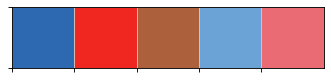

In [9]:
sns.palplot(palettable.tableau.BlueRed_6.hex_colors[:5])
ctcolors = palettable.tableau.BlueRed_6.hex_colors[:5]
ctmap = {'Neut':ctcolors[4], 'Mono':ctcolors[2], 'cDC':ctcolors[3], 'pDC':ctcolors[0]}
obs['ctcolor'] = obs['Grouped_Clustering'].replace(ctmap)


In [10]:
from matplotlib import gridspec
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Myriad Pro']

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

rcParams['xtick.major.pad']='1'
rcParams['ytick.major.pad']='1'

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

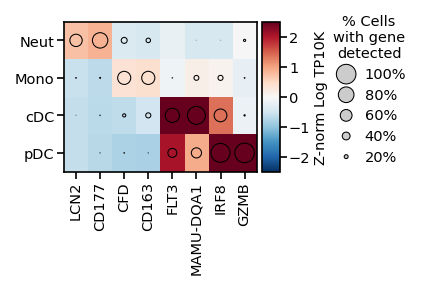

In [32]:
percent_positive = expression.groupby(obs['Grouped_Clustering']).agg(lambda x: (x>0).mean())

expression_norm = expression.copy()
expression_norm = expression_norm.subtract(expression_norm.mean(axis=0), axis=1)
expression_norm = expression_norm.divide(expression_norm.std(axis=0), axis=1)
average_expression = expression_norm.groupby(adata_2.obs['Grouped_Clustering']).mean()

width=2.65
heatmap_width=1.42
legend_width=1.1
left_space=.13

heatmap_height = 1.0
bottom_space = .4
top_space = .2
height=heatmap_height+bottom_space+top_space

topval = 1-(top_space/height)
bottomval = bottom_space/height

fig = plt.figure(figsize=(width, height), dpi=150)
full_gs = gridspec.GridSpec(
        nrows=1,
        ncols=2,
        wspace=0,
        hspace=0,
        width_ratios=[
            heatmap_width,
            legend_width,
        ], left=left_space, right=.99, bottom=bottomval, top=topval)


legend_grid = full_gs[0, 1].subgridspec(1, 130, wspace=0, hspace=0,
                                           width_ratios=[.01]*130)

cbar_ax = fig.add_subplot(legend_grid[5:20], ylim=[0,1], xlim=[0,1], frameon=False)
size_legend_ax = fig.add_subplot(legend_grid[50:], ylim=[0,1], xlim=[0,1], frameon=False, yticks=[], xticks=[])

heatmap_ax = fig.add_subplot(full_gs[0])

alldotsize = percent_positive.copy()
alldotsize = alldotsize - alldotsize.min().min()
alldotsize = alldotsize / alldotsize.max().max()
alldotsize = (alldotsize * 9.4) ** 2

allcolors = average_expression.copy()
vmin=-2.5
vmax=2.5
cmap = "RdBu_r"

cim= heatmap_ax.imshow(allcolors.loc[celltype_order, genes_to_plot], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
heatmap_ax.grid(False)
heatmap_ax.set_yticks(np.arange(len(celltype_order)))
heatmap_ax.set_yticklabels(celltype_order)

heatmap_ax.set_xticks(np.arange(len(genes_to_plot)))
heatmap_ax.set_xticklabels(genes_to_plot, rotation=90)
#heatmap_ax.set_title('Myeloid - Seq-Well', pad=0)

for (x, g) in enumerate(genes_to_plot):
    for (y, ct) in enumerate(celltype_order):
        dotsize = alldotsize.loc[ct,g]
        heatmap_ax.scatter(x, y, color="none", marker='o',
                                      s=dotsize, norm=None,
                                       edgecolor='k', linewidth=.5)

        
        
        

plt.colorbar(cim, cax=cbar_ax,)
#matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=normalize, ticks=[0,1,2,3,4,5,6,7])


vals = np.linspace(.2, 1, num=5)
leg_dot_size =  (vals * 9.4) ** 2
leg_dot_color = 'k'
text_offset = .2
leg_x_pos = .35

leg_x = np.array([leg_x_pos]*5)
leg_y = np.linspace(.1, .65, 5)

sizelegendfontsize = 7
size_legend_ax.scatter(leg_x, leg_y, s=leg_dot_size, edgecolor='k',  linewidth=.5, c='.8')
size_legend_ax.text(0, .5, 'Z-norm Log TP10K', fontsize=sizelegendfontsize, ha='left', va='center', rotation=90)
for i in range(5):
    size_legend_ax.text(leg_x[i]+text_offset, leg_y[i], ('%d' % (100*vals[i])) + '%', fontsize=sizelegendfontsize, va='center')
size_legend_ax.text(.6, 1.05, '% Cells\nwith gene\ndetected', ha='center', va='top', fontsize=sizelegendfontsize)
      
    
figure_file = os.path.join(results_dir, "Subcluster.Myeloid.Seqwell.Invivo.Dotplot.pdf")
fig.savefig(figure_file, dpi=200)


In [28]:
box_height=1.5
box_width=1.5
title_height=.15
left_space = .02
right_space = .98
bottom_space = .02
top_space = .98

dotsize=.5
valdpi = 200

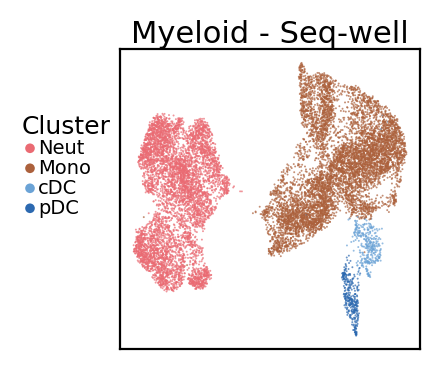

In [31]:
leg_width=.5
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(leg_width, box_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 1],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])


ax.scatter(obs['UMAP_1'], obs['UMAP_2'], c=obs['ctcolor'],
           s=dotsize, alpha=.7, edgecolor='None', rasterized=True)

legend_ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
marker_x=.05

marker_x=.1
N = len(celltype_order)
for (i,y) in enumerate(np.linspace(.67, .47, num=N)):
  ct = celltype_order[i]
  legend_ax.scatter(marker_x, y, color=ctmap[ct], s=12, edgecolor='None')
  legend_ax.text(marker_x+.08, y-.015, ct, fontsize=7)
legend_ax.text(.02, .72, 'Cluster', fontsize=9)

title_ax = fig.add_subplot(gs[0, 1],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, 'Myeloid - Seq-well', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "Subcluster.UMAP.Myeloid.Seqwell.Invivo.Celltype.pdf")
fig.savefig(figure_file, dpi=300)